In [1]:
import os
import matplotlib.pyplot as plt
import cv2

# Chemin vers le dataset Kaggle
base_dir = "/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)"

# Voir les classes disponibles
classes = os.listdir(base_dir)
print("Classes disponibles :", classes)

# Compter le nombre d’images dans chaque classe
for cls in classes:
    path = os.path.join(base_dir, cls)
    count = len(os.listdir(path))
    print(f"{cls} : {count} images")

# Vérifier la taille des images
img_path = os.path.join(base_dir, classes[0], os.listdir(os.path.join(base_dir, classes[0]))[0])
img = cv2.imread(img_path)
print("Taille : ", img.shape) 

Classes disponibles : ['Non Drowsy', 'Drowsy']
Non Drowsy : 19445 images
Drowsy : 22348 images
Taille :  (227, 227, 3)


In [2]:
import os
import random
import shutil

output_dir = "/kaggle/working/dataset_splited"
classes = ["Drowsy", "Non Drowsy"]

random.seed(42) 

# Créer les dossiers
for folder in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(output_dir, folder, cls), exist_ok=True)

test_ratio = 0.15
val_ratio = 0.15

for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    test_count = int(total * test_ratio)
    val_count = int(total * val_ratio)

    test_imgs = images[:test_count]
    val_imgs = images[test_count:test_count + val_count]
    train_imgs = images[test_count + val_count:]

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, "train", cls))

    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, "val", cls))

    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, "test", cls))

In [3]:
# Vérifier le nombre d’images dans chaque split
for folder in ["train", "val", "test"]:
    for cls in classes:
        path = os.path.join(output_dir, folder, cls)
        print(folder, cls, ":", len(os.listdir(path)))

train Drowsy : 15644
train Non Drowsy : 13613
val Drowsy : 3352
val Non Drowsy : 2916
test Drowsy : 3352
test Non Drowsy : 2916


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

IMG_SIZE = (299, 299)
BATCH_SIZE = 32

train_dir = "/kaggle/working/dataset_splited/train"
val_dir = "/kaggle/working/dataset_splited/val"
test_dir = "/kaggle/working/dataset_splited/test"

# Train generator (avec augmentation)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation et Test
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Charger les images avec flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

2025-11-05 22:53:20.163574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762383200.361786      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762383200.417260      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 29257 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Taille des images
IMG_SIZE = (299, 299, 3)

# Charger InceptionV3 sans la tête (include_top=False)
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=IMG_SIZE))

# Ne pas entraîner les couches pré-entraînées
for layer in base_model.layers:
    layer.trainable = False

# Ajouter les couches pour notre tâche
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  

# Créer le modèle complet
model = Model(inputs=base_model.input, outputs=output)

# Compiler le modèle
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Afficher le résumé
model.summary()

I0000 00:00:1762383218.171887      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762383218.172586      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,073,377 (84.20 MB)

 Trainable params: 270,593 (1.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callback pour arrêter l'entraînement si la validation ne s'améliore pas
early_stop = EarlyStopping(
    monitor='val_loss',   
    patience=3,              
    restore_best_weights=True
)

# Callback pour sauvegarder le meilleur modèle
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_model.h5', 
    monitor='val_loss',                        
    save_best_only=True,
    verbose=1
)

# Entraînement
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/15
914/914 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.6956 - loss: 0.5622
Epoch 1: val_loss improved from inf to 0.17744, saving model to /kaggle/working/best_model.h5
914/914 ━━━━━━━━━━━━━━━━━━━━ 629s 688ms/step - accuracy: 0.6957 - loss: 0.5620 - val_accuracy: 0.9412 - val_loss: 0.1774
Epoch 2/15
  1/914 ━━━━━━━━━━━━━━━━━━━━ 1:59 131ms/step - accuracy: 0.9375 - loss: 0.2666

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.17744 to 0.17740, saving model to /kaggle/working/best_model.h5
914/914 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - accuracy: 0.9375 - loss: 0.2666 - val_accuracy: 0.9412 - val_loss: 0.1774
Epoch 3/15
914/914 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.9298 - loss: 0.2002
Epoch 3: val_loss improved from 0.17740 to 0.05200, saving model to /kaggle/working/best_model.h5
914/914 ━━━━━━━━━━━━━━━━━━━━ 610s 667ms/step - accuracy: 0.9299 - loss: 0.2001 - val_accuracy: 0.9878 - val_loss: 0.0520
Epoch 4/15
  1/914 ━━━━━━━━━━━━━━━━━━━━ 2:01 133ms/step - accuracy: 0.8750 - loss: 0.1461
Epoch 4: val_loss improved from 0.05200 to 0.05174, saving model to /kaggle/working/best_model.h5
914/914 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - accuracy: 0.8750 - loss: 0.1461 - val_accuracy: 0.9880 - val_loss: 0.0517
Epoch 5/15
914/914 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.9659 - loss: 0.1061
Epoch 5: val_loss improved from 0.05174 to 0.02642, saving model to /kaggle/work

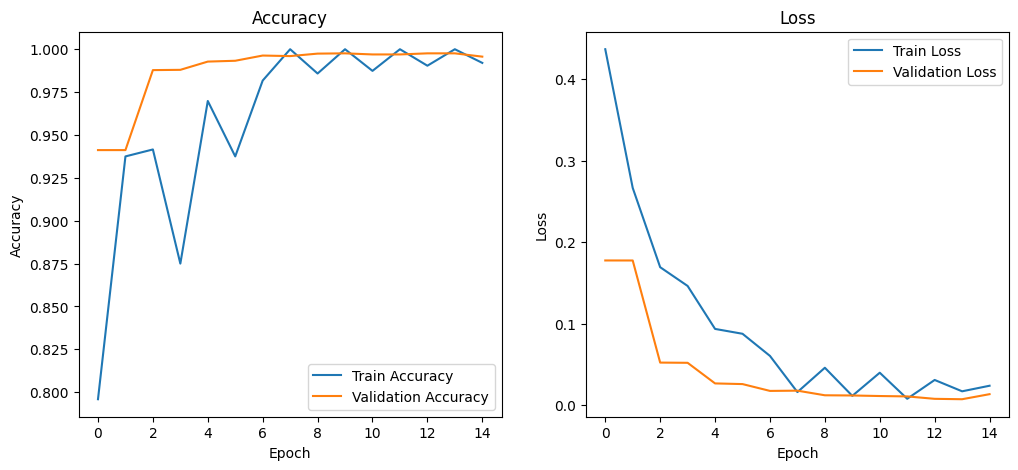

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plot accuracy et loss depuis l'historique
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 299, 299, 3))
  warnings.warn(msg)


195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 299, 299, 3))
  warnings.warn(msg)


196/196 ━━━━━━━━━━━━━━━━━━━━ 54s 243ms/step
              precision    recall  f1-score   support

      Drowsy       1.00      1.00      1.00      3352
  Non Drowsy       1.00      1.00      1.00      2916

    accuracy                           1.00      6268
   macro avg       1.00      1.00      1.00      6268
weighted avg       1.00      1.00      1.00      6268



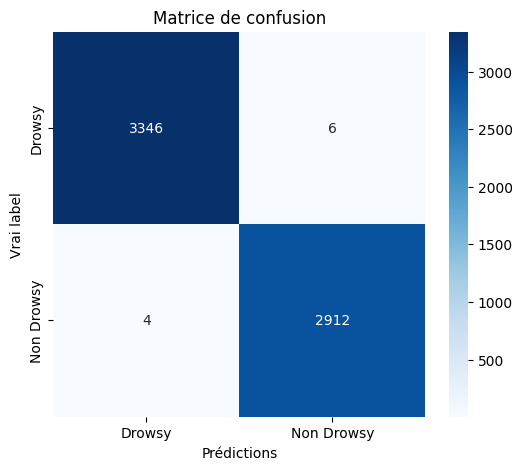

In [9]:
# Assurer que le générateur test est au début
test_generator.reset()

# Prédictions sur le test set
y_pred_prob = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()  # seuil 0.5 pour classification binaire

# Labels réels
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Prédictions")
plt.ylabel("Vrai label")
plt.title("Matrice de confusion")
plt.show()

